# 5 to 8 Model!

## Imports and Setting Up Data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import pickle
import matplotlib.pyplot as plt
import os
import cv2
from tqdm.autonotebook import tqdm
from keras import layers
from keras.callbacks import LearningRateScheduler

import torch
import math
from torch import nn

%matplotlib inline

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == "__main__":


In [2]:
with open("../input/weather-data/data.pkl", "rb") as f:
    l = pickle.load(f)

The 2 functions below are custom resizers, because cv2 resize gets jank with really low resolutions

In [3]:
def mean_conv_2(img):
    size = 2
    stride = 2
    ret = np.ones((8,8))
    stx=0
    for i in range(8):
        sty = 0
        for j in range(8):
            ret[i][j] = np.mean(img[stx:stx+size, sty:sty+size])
            sty += stride
        stx += stride
    
    return ret

In [4]:
def mean_conv(img):
    size = 2
    stride = 2
    ret = np.ones((16,16))
    stx=0
    for i in range(16):
        sty = 0
        for j in range(16):
            ret[i][j] = np.mean(img[stx:stx+size, sty:sty+size])
            sty += stride
        stx += stride
    
    return ret

In [5]:
SIZE = 32
high_img = []
for i in tqdm(range(len(l))):
    img = l[i]
    img[np.isnan(img)]=np.mean(img[~np.isnan(img)])
    if (i!=0 and np.array_equal(img, previmg)):
        continue
    previmg = img
    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    img = mean_conv(img)
    img = img / img.max()
    high_img.append(img)

  0%|          | 0/3600 [00:00<?, ?it/s]

In [6]:
high_img = np.unique(np.array(high_img), axis=0)
high_img.shape

(1984, 16, 16)

In [7]:
SIZE = 16
temp_img = []
low_img = []
for i in tqdm(range(len(high_img))):
    img = high_img[i]
    #resizing image
    temp = mean_conv_2(img)
    temp_img.append(temp)
    img = cv2.resize(temp, (SIZE, SIZE), interpolation=cv2.INTER_CUBIC)
    low_img.append(img)

  0%|          | 0/1984 [00:00<?, ?it/s]

In [8]:
high_img = np.array(high_img)
low_img = np.array(low_img)
temp_img = np.array(temp_img)

In [9]:
def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) and len(b) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

In [10]:
high_img, low_img, temp_img = unison_shuffled_copies(high_img, low_img, temp_img)

Let's see some images

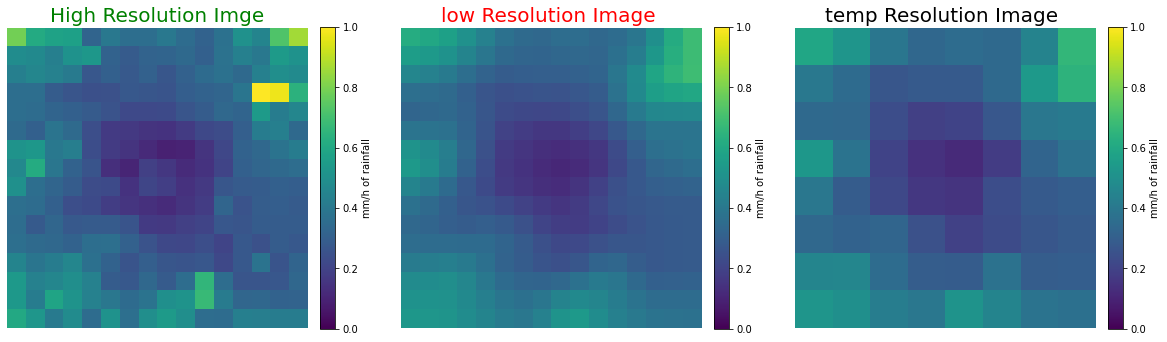

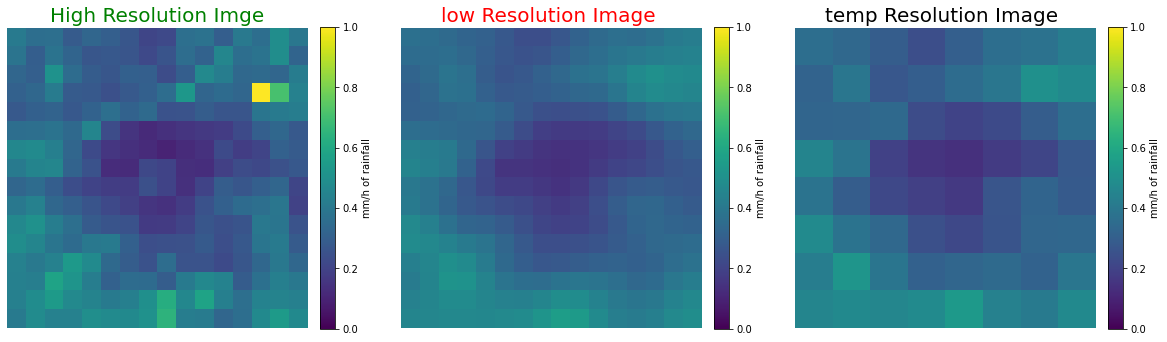

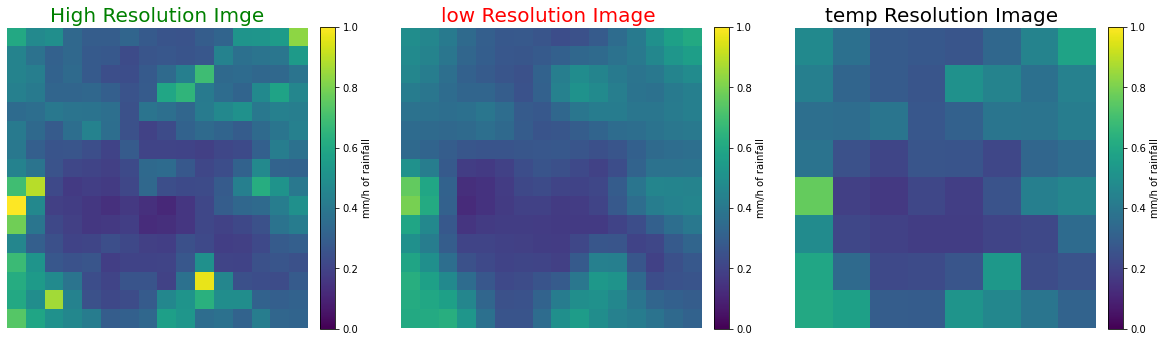

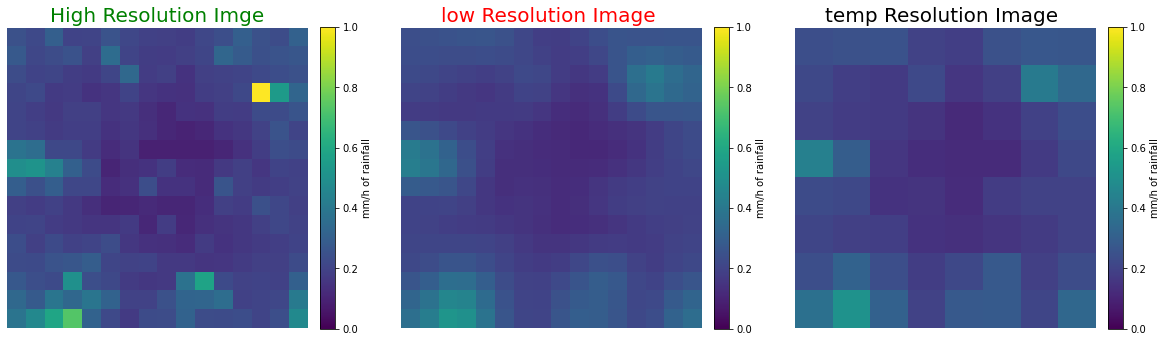

In [11]:
for i in range(4):
    a = np.random.randint(0,1984)
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a], vmin=0)
    plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel("mm/h of rainfall")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title('low Resolution Image ', color = 'red', fontsize = 20)
    plt.imshow(low_img[a], vmin=0, vmax=high_img[a].max())
    plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel("mm/h of rainfall")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title('temp Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(temp_img[a], vmin=0, vmax=high_img[a].max())
    plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel("mm/h of rainfall")
    plt.axis('off')

In [12]:
train_high_image = high_img[:1269]
train_low_image = low_img[:1269]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,1))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,1))

validation_high_image = high_img[1269:1587]
validation_low_image = low_img[1269:1587]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,1))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,1))


test_high_image = high_img[1587:]
test_low_image = low_img[1587:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,1))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,1))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (1269, 16, 16, 1)
Shape of test images: (397, 16, 16, 1)
Shape of validation images: (318, 16, 16, 1)


There are multiple classes here, but the only important one is the UNetBlock. The rest were found to cause very high variance.

In [13]:
class ExtrapolateBlock(keras.layers.Layer):
    def __init__(self):
        super(ExtrapolateBlock, self).__init__()
        self.e1 = layers.Conv2D(2,(3,3),padding = 'same', activation='relu')
        self.e2 = layers.Conv2D(4,(3,3),padding = 'same', activation='relu')
        self.e3 = layers.Conv2D(8,(3,3),padding = 'same', activation='relu')
    def call(self, inputs):
        ret1 = self.e1(inputs)
        ret2 = self.e2(ret1)
        ret3 = self.e3(ret2)
        return ret3

class CompressBlock(keras.layers.Layer):
    def __init__(self):
        super(CompressBlock, self).__init__()
        self.d1 = layers.Conv2D(4,(3,3),padding = 'same', activation='relu')
        self.d2 = layers.Conv2D(2,(3,3),padding = 'same', activation='relu')
        self.d3 = layers.Conv2D(1,(3,3),padding = 'same', activation='relu')
    def call(self, inputs):
        ret = self.d1(inputs)
        ret = self.d2(ret)
        ret = self.d3(ret)
        return ret

class UNetBlock(keras.layers.Layer):
    def __init__(self):
        super(UNetBlock, self).__init__()
        self.down1 = self.down(128,(3,3),False)
        self.down2 = self.down(128,(3,3),False)
        self.down3 = self.down(256,(3,3),False)
        self.down4 = self.down(512,(3,3),False)
        
        self.up1 = self.up(256,(3,3),False)
        self.up2 = self.up(128,(3,3),False)
        self.up3 = self.up(128,(3,3),False)
        self.up4 = self.up(64,(3,3),False)
        
        self.out = layers.Conv2D(8, (3,3), padding = 'same', activation='relu')
        
    def call(self, inputs):
        d1 = self.down1(inputs)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        
        u1 = self.up1(d4)
        u1 = layers.concatenate([u1, d3])
        u2 = self.up2(u1)
        u2 = layers.concatenate([u2, d2])
        u3 = self.up3(u2)
        u3 = layers.concatenate([u3, d1])
        u4 = self.up4(u3)
        u4 = layers.concatenate([u4, inputs])
        
        output = self.out(u4)
        return output
        
    def down(self, filters , kernel_size, apply_batch_normalization = True):
        downsample = tf.keras.models.Sequential()
        downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2, activation='relu'))
        if apply_batch_normalization:
            downsample.add(layers.BatchNormalization())
        downsample.add(keras.layers.LeakyReLU())
        return downsample
    
    def up(self, filters, kernel_size, dropout = False):
        upsample = tf.keras.models.Sequential()
        upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2, activation='relu'))
        if dropout:
            upsample.dropout(0.2)
        upsample.add(keras.layers.LeakyReLU())
        return upsample

Previous attempted models, for reference

In [14]:
# def seq_model(euc_rep=1, unet_rep=1):
#     assert euc_rep > 0
#     assert unet_rep > 0
#     model = keras.Sequential()
#     model.add(layers.Input(shape=[SIZE,SIZE,1]))
#     for i in range(euc_rep):
#         model.add(ExtrapolateBlock())
        
#         for j in range(unet_rep):
#             model.add(UNetBlock())
            
#         model.add(CompressBlock())
    
#     return model

In [15]:
# def non_seq_model():
#     # The plan is to add more of these but then also add skip connections (hence no sequential)
#     inputs = layers.Input(shape=[SIZE,SIZE,1])
#     extr = ExtrapolateBlock()(inputs)
#     unet = UNetBlock()(extr)
#     comp = CompressBlock()(unet)
# #     comp2 = layers.concatenate([comp2, inputs])
#     conv = layers.Conv2D(1, (2,2), padding = 'same', activation='relu')(comp)
#     return tf.keras.Model(inputs=inputs, outputs=conv)

In [16]:
# def srcnn_model():
#     model = keras.Sequential()
#     model.add(layers.Input(shape=[SIZE,SIZE,1]))
#     model.add(layers.Conv2D(64, (9,9), padding='same', activation='relu'))
#     model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu'))    
#     model.add(layers.Conv2D(1, (5,5), padding='same', activation='relu'))
#     return model

Here it is, the UNet Model!

In [17]:
def unet_model():
    model = keras.Sequential()
    model.add(layers.Input(shape=[SIZE,SIZE,1]))
    model.add(UNetBlock())
    model.add(layers.Conv2D(1, (1,1), padding='same', activation='relu'))
    
    return model

In [18]:
model = unet_model()
model.summary()

2022-08-23 14:47:27.128294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 14:47:27.129827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 14:47:27.130807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 14:47:27.132038: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
u_net_block (UNetBlock)      (None, 16, 16, 8)         3841296   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 1)         9         
Total params: 3,841,305
Trainable params: 3,841,305
Non-trainable params: 0
_________________________________________________________________


We compile with Adam with an lr of 0.001 and a standard epsilon. The loss is MAE, and we have an additional metric of RMSE.

In [19]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, epsilon=1e-08), loss = 'mean_absolute_error',
              metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [20]:
# first_decay_steps = 20
# lr_decayed_fn = (
#   tf.keras.optimizers.schedules.CosineDecayRestarts(
#       0.001,
#       first_decay_steps,
#       alpha=0.01
#   ))
# lr = LearningRateScheduler(lr_decayed_fn)

In [21]:
checkpoint_filepath = 'md_8_16_best'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_root_mean_squared_error',
    mode='min',
    save_best_only=True)

Training the model while saving the best validation scores

In [22]:
hist = model.fit(train_low_image, train_high_image, epochs = 60, batch_size = 8,
        validation_data = (validation_low_image,validation_high_image),
        callbacks=[model_checkpoint_callback]
                )

2022-08-23 14:47:32.394986: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-08-23 14:47:33.946376: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


159/159 [==============================] - 9s 11ms/step - loss: 0.0402 - root_mean_squared_error: 0.0763 - val_loss: 0.0312 - val_root_mean_squared_error: 0.0573
Epoch 2/60
159/159 [==============================] - 1s 7ms/step - loss: 0.0298 - root_mean_squared_error: 0.0546 - val_loss: 0.0297 - val_root_mean_squared_error: 0.0548
Epoch 3/60
159/159 [==============================] - 1s 7ms/step - loss: 0.0286 - root_mean_squared_error: 0.0524 - val_loss: 0.0289 - val_root_mean_squared_error: 0.0532
Epoch 4/60
159/159 [==============================] - 1s 7ms/step - loss: 0.0278 - root_mean_squared_error: 0.0508 - val_loss: 0.0285 - val_root_mean_squared_error: 0.0524
Epoch 5/60
159/159 [==============================] - 1s 8ms/step - loss: 0.0274 - root_mean_squared_error: 0.0497 - val_loss: 0.0282 - val_root_mean_squared_error: 0.0516
Epoch 6/60
159/159 [==============================] - 1s 7ms/step - loss: 0.0268 - root_mean_squared_error: 0.0486 - val_loss: 0.0278 - val_root_mean_

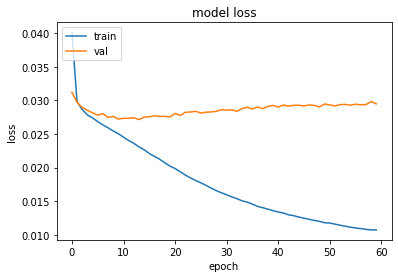

In [23]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

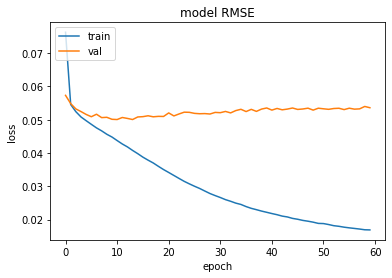

In [24]:
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Let's load the weights of the best model (according to the validation rmse)

In [25]:
model.load_weights(checkpoint_filepath)

Let's see how it did (visually)!

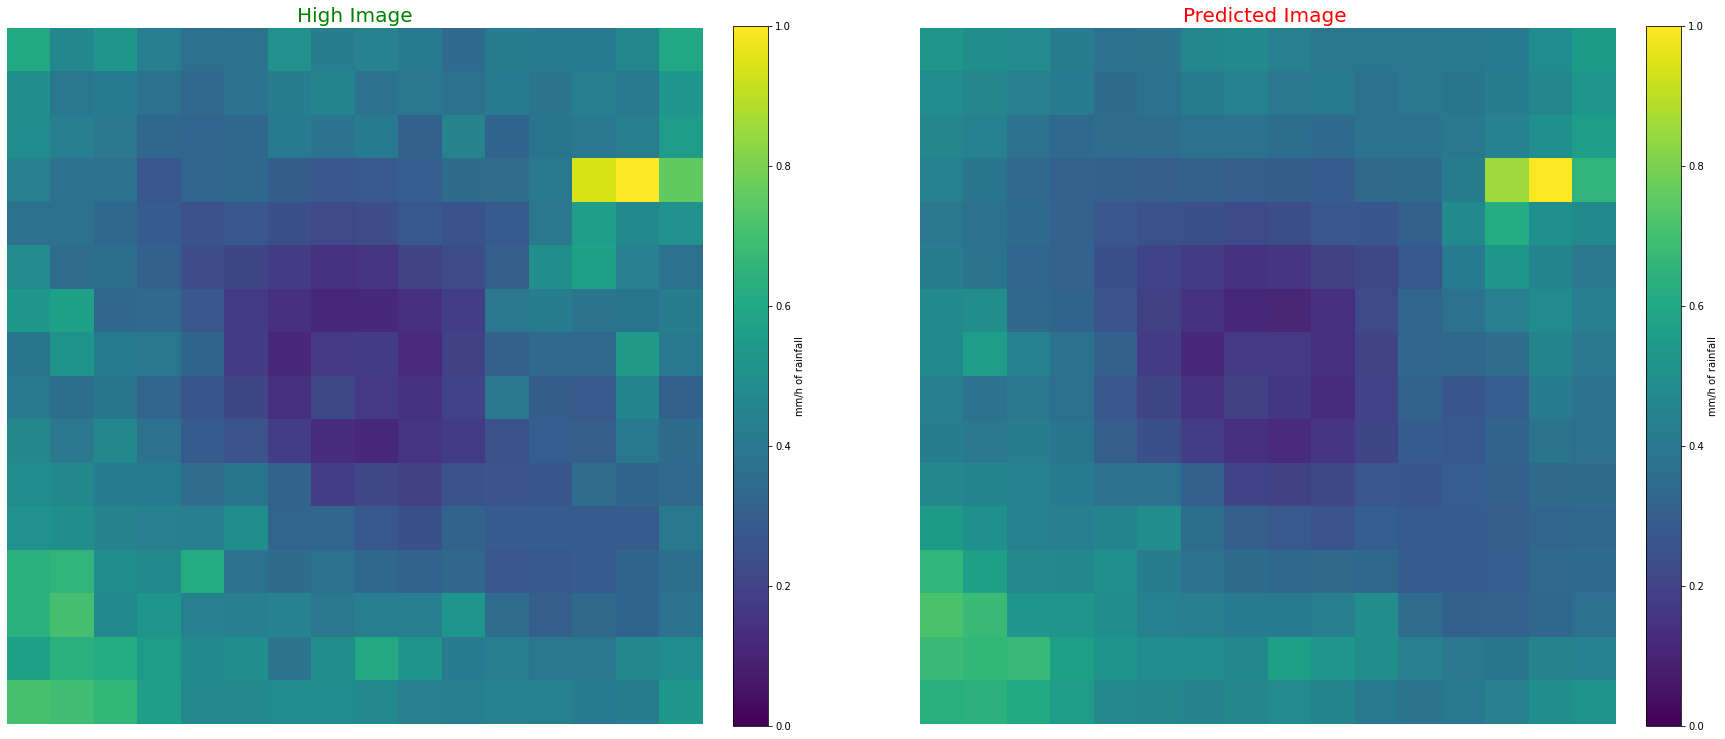

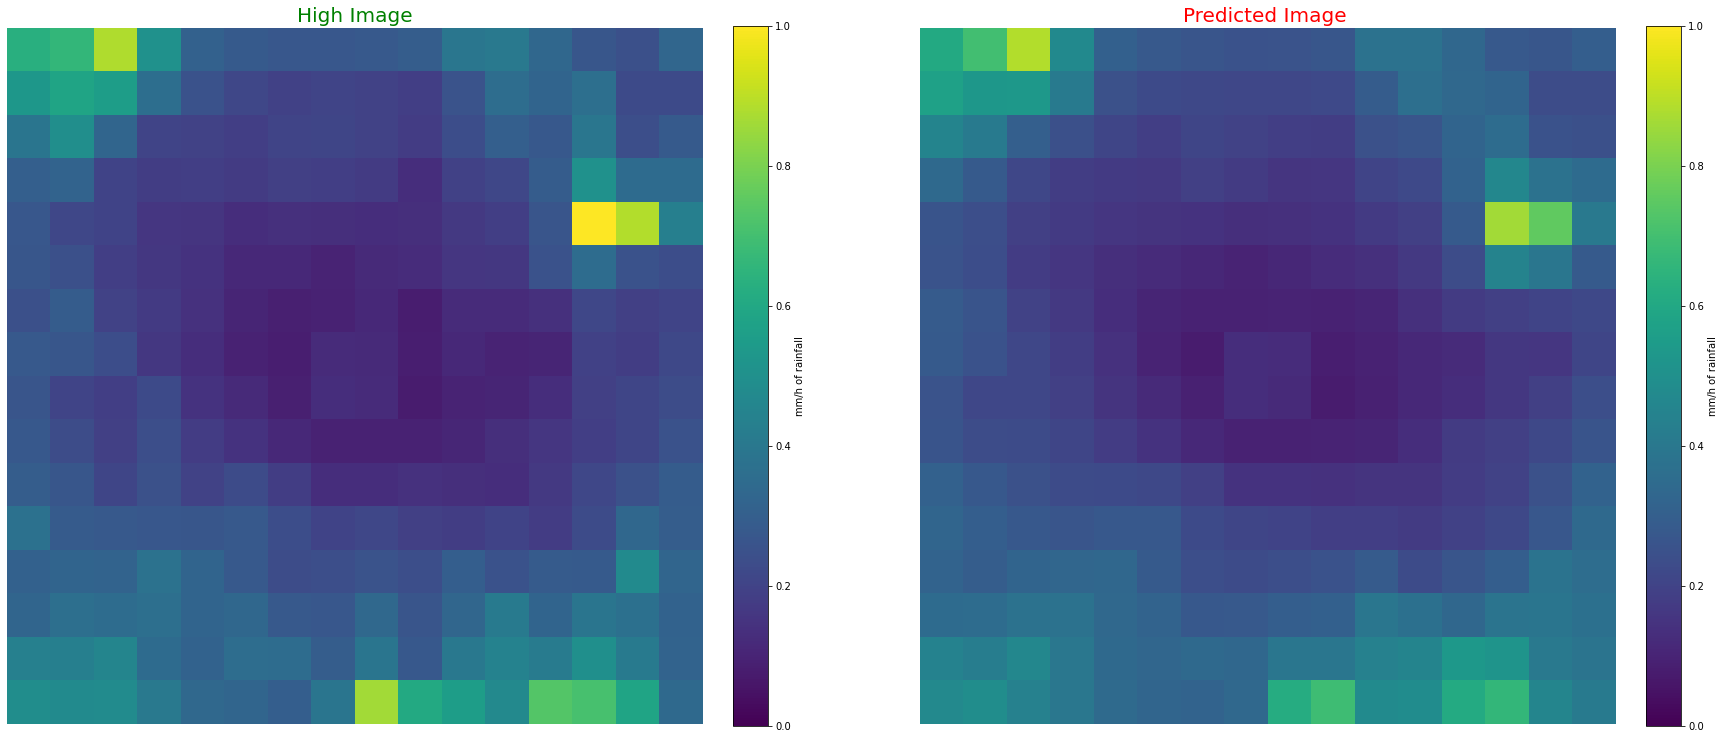

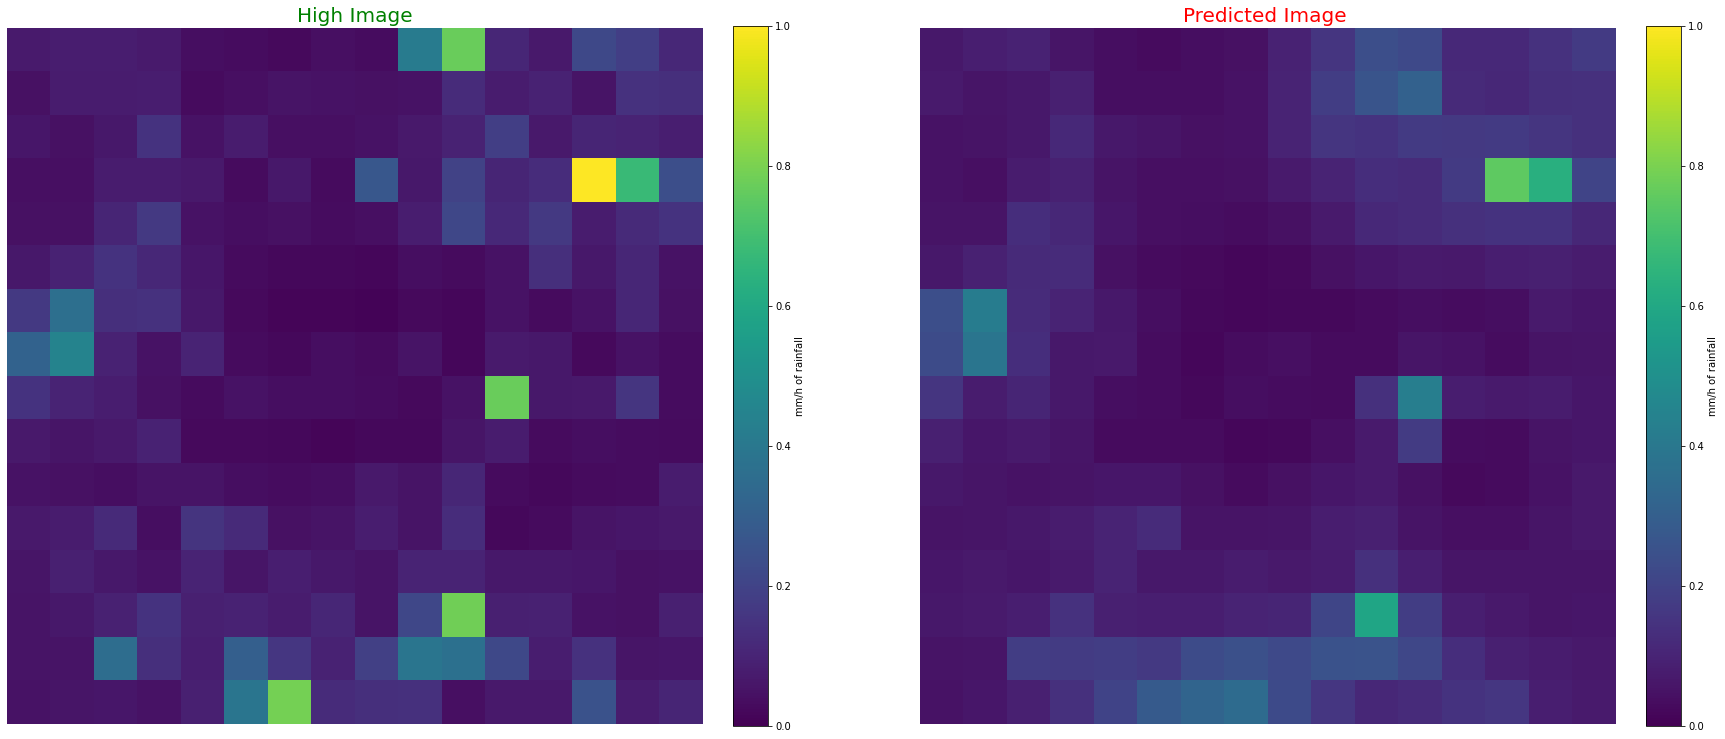

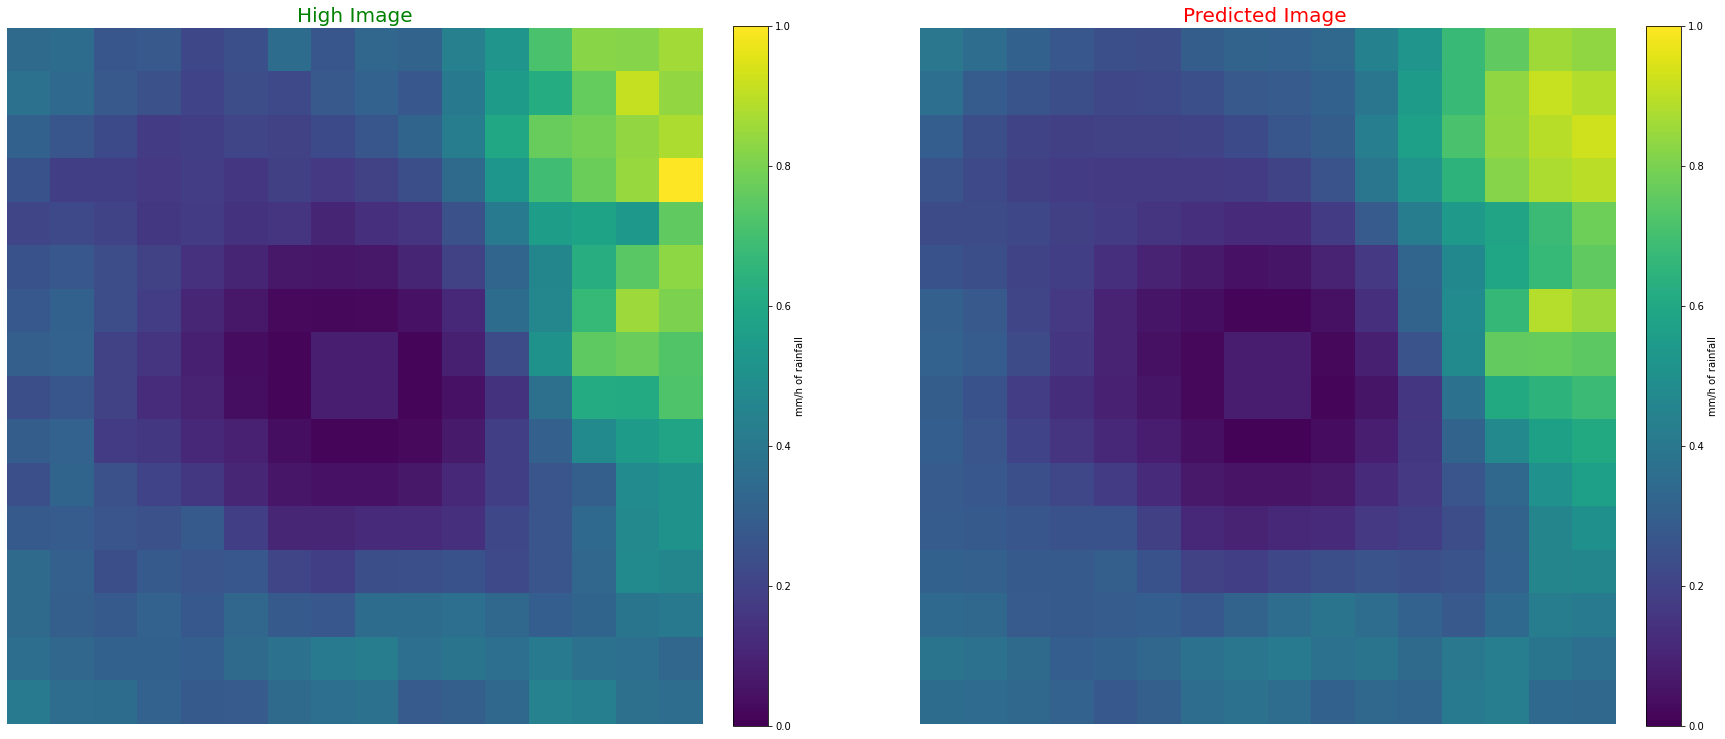

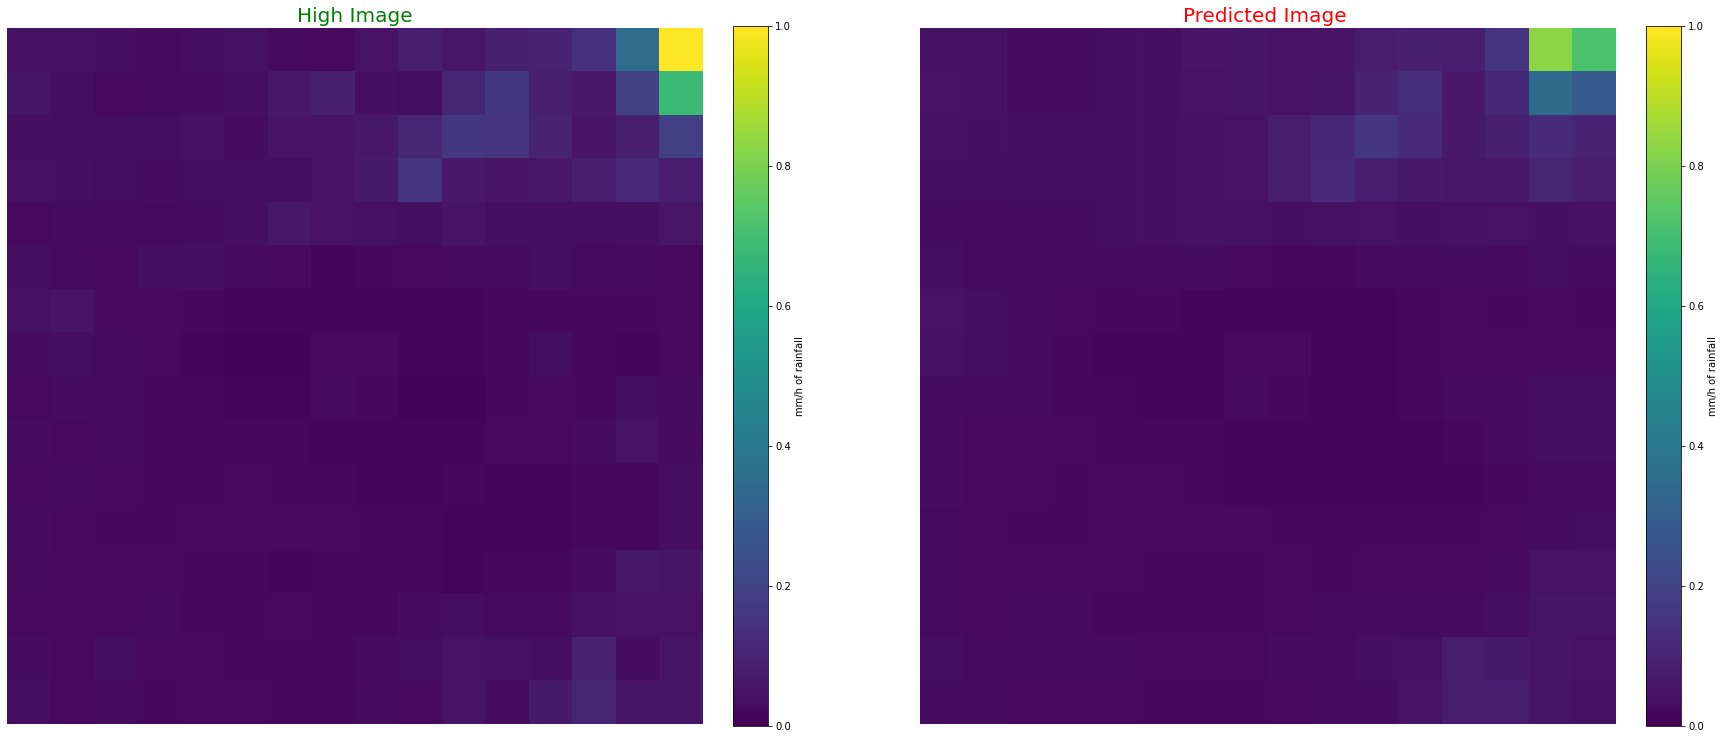

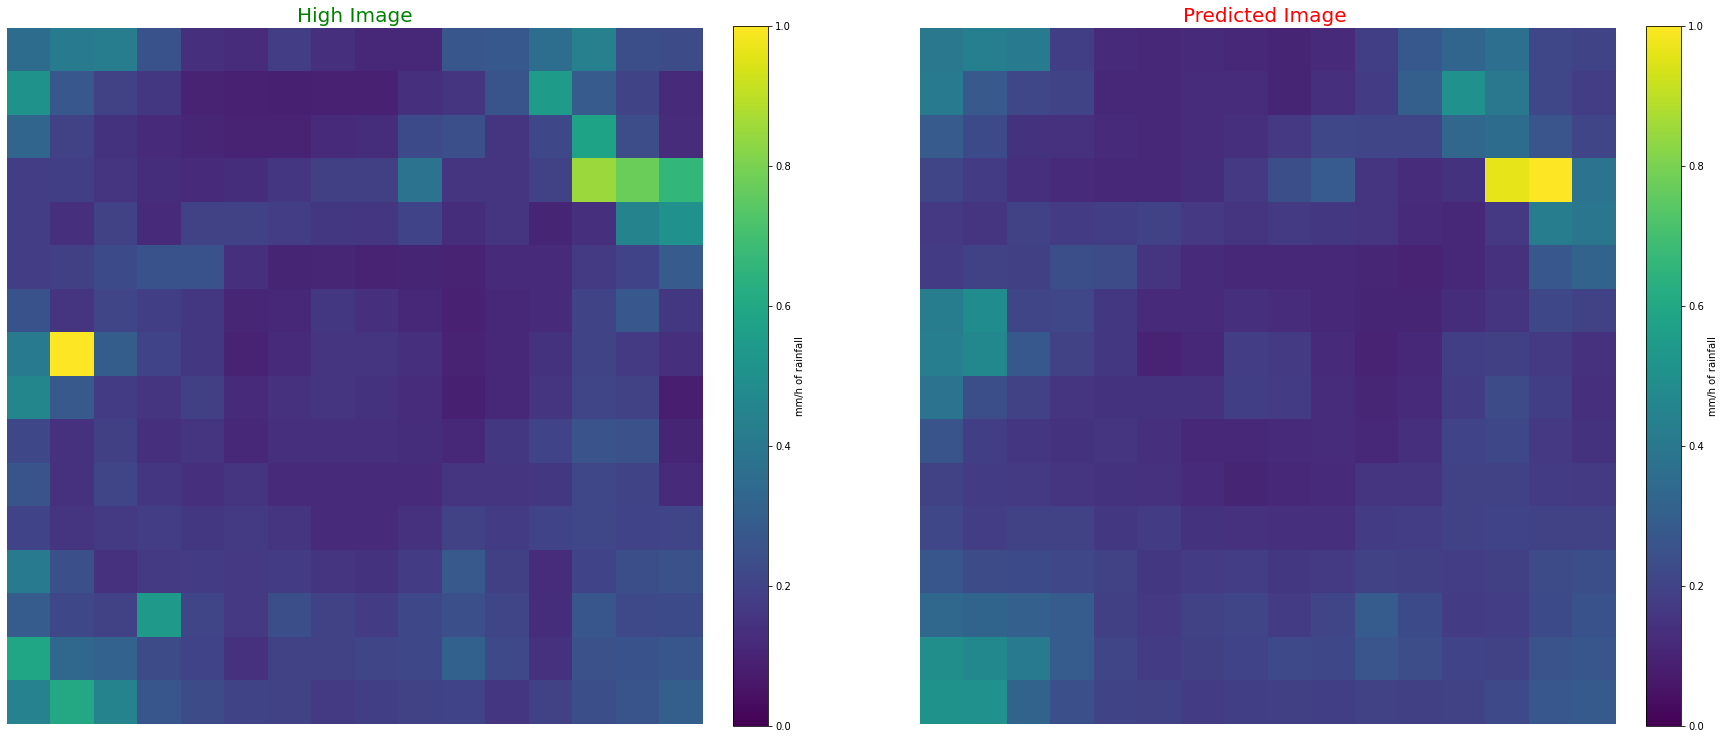

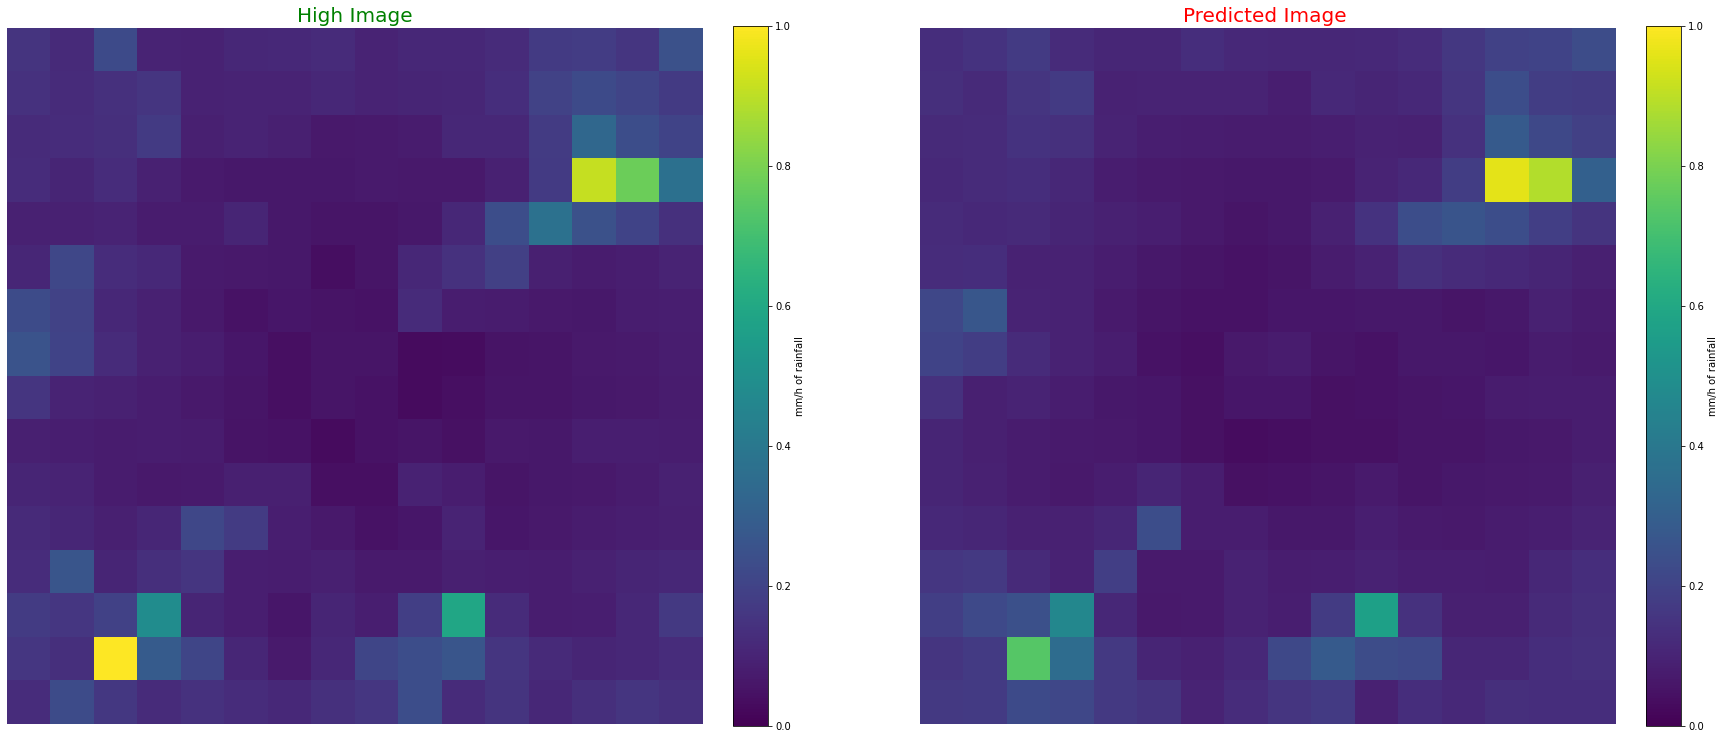

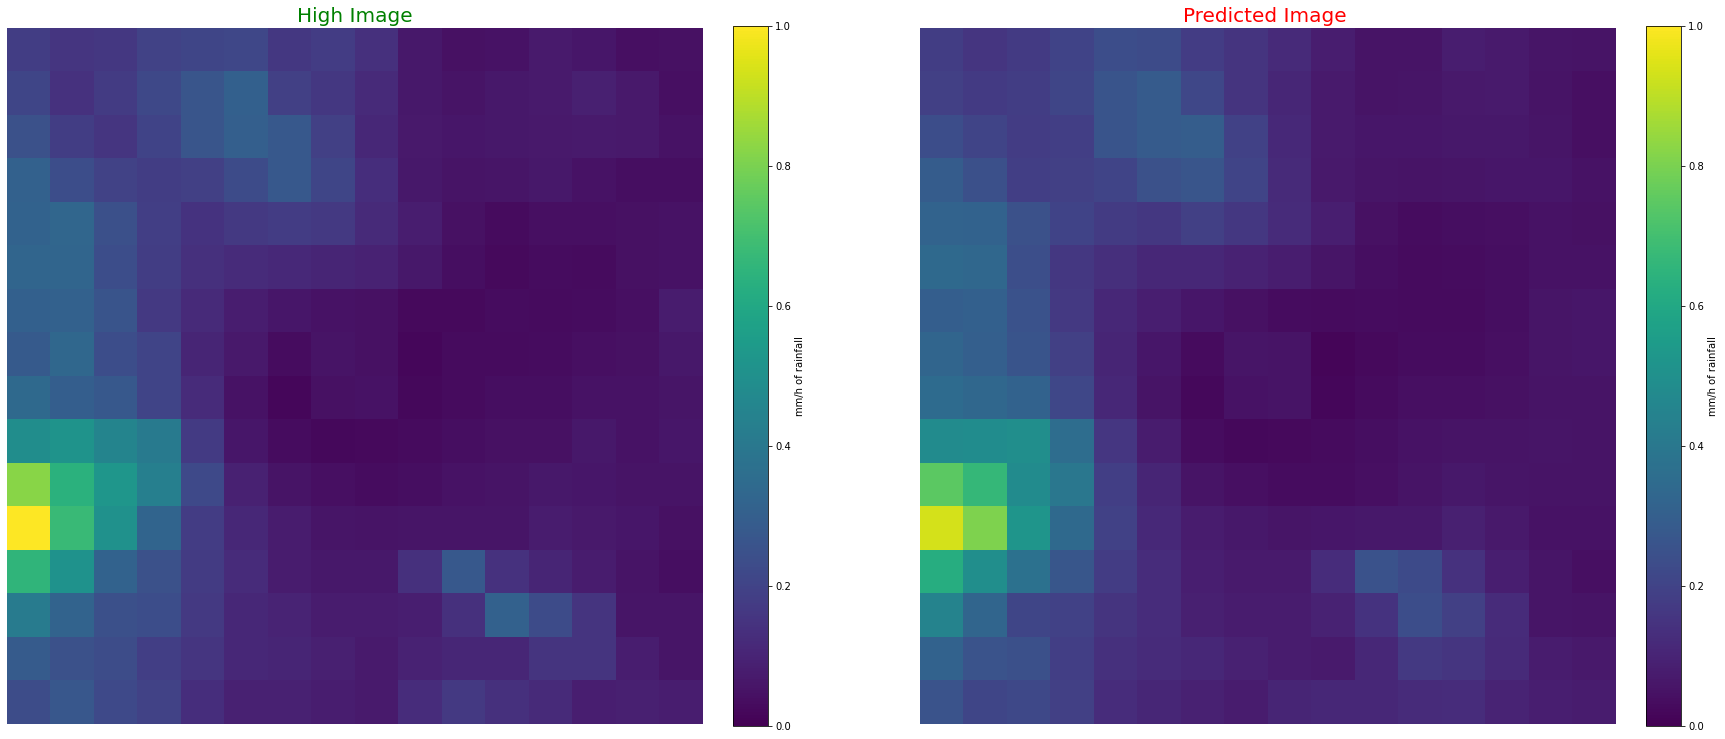

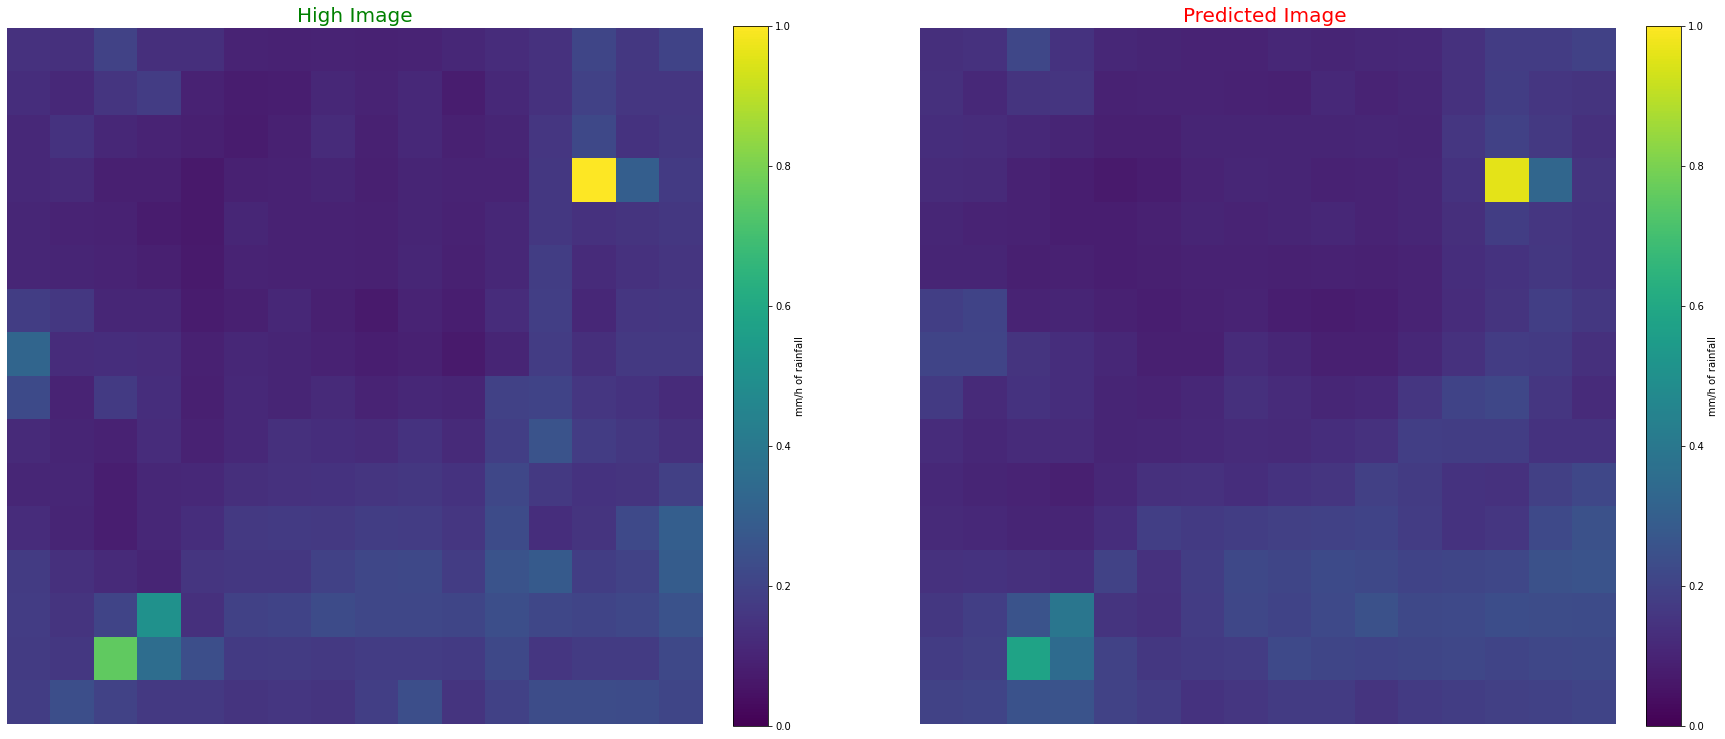

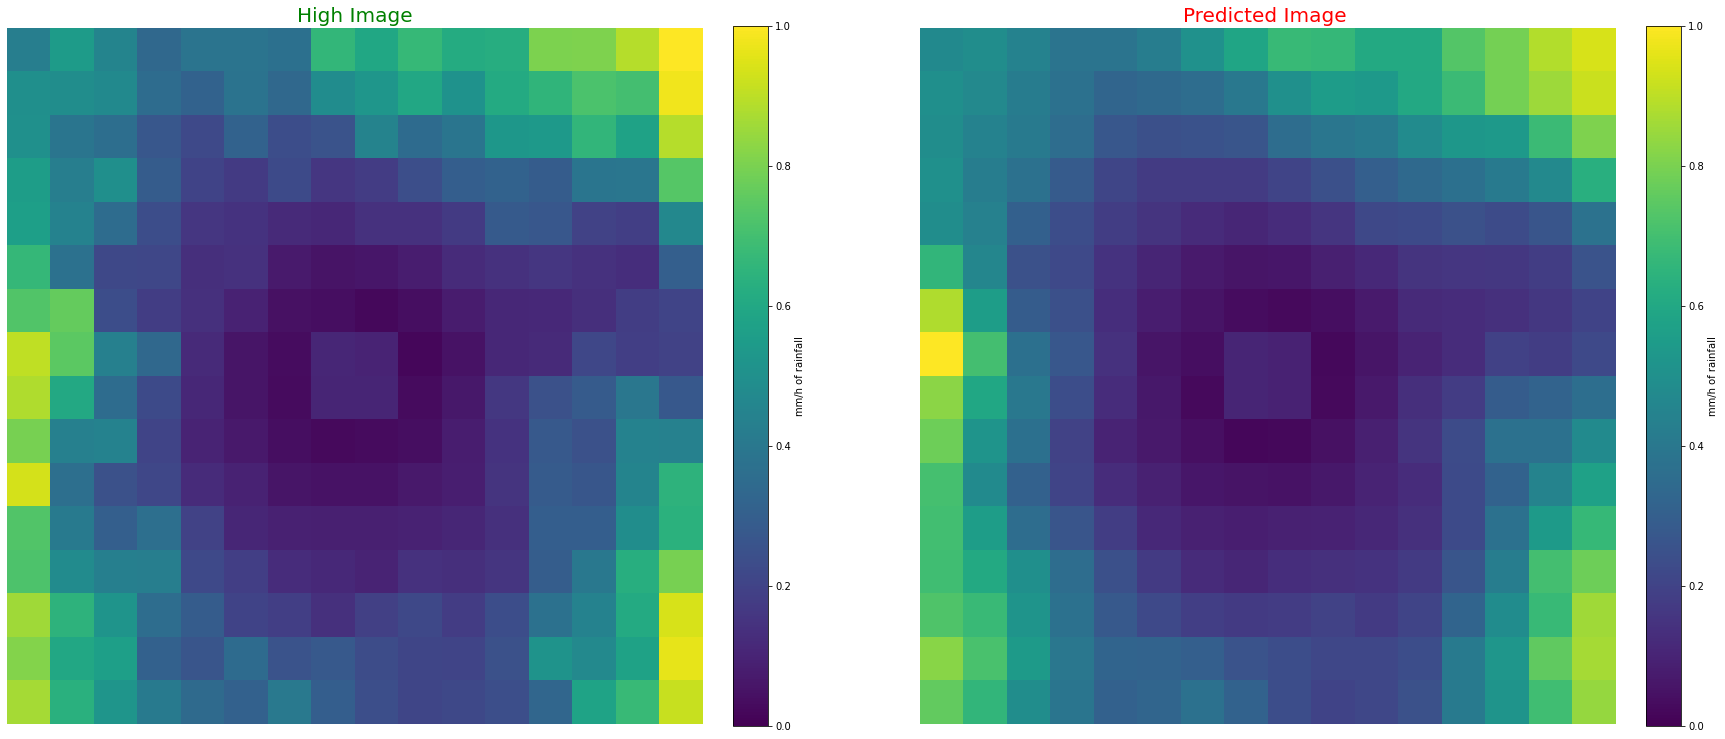

In [26]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(30,30))
    plt.subplot(1,2,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high, vmin=0, vmax=high.max())
    plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel("mm/h of rainfall")
    plt.axis('off')    
    
#     plt.subplot(1,3,2)
#     plt.title('Low Image ', color = 'black', fontsize = 20)
#     plt.imshow(low, vmin=0, vmax=high.max())
#     plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel("mm/h of rainfall")
#     plt.axis('off')    
    
    plt.subplot(1,2,2)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted, vmin=0, vmax=high.max())
    plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel("mm/h of rainfall")
    plt.axis('off')    
    
    plt.show()
""
for i in range(150,160):
    
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,1)),0.0,1.0).reshape(SIZE, SIZE,1)
    plot_images(test_high_image[i],test_low_image[i],predicted)

Evaluate on the test set!

In [27]:
res = model.evaluate(test_low_image, test_high_image, batch_size=1)

397/397 [==============================] - 1s 3ms/step - loss: 0.0269 - root_mean_squared_error: 0.0493
